In [1]:
import pandas as pd
import numpy as np
from datasets import Dataset
from collections import Counter
import gc
import warnings
import time
import psutil
import os
warnings.filterwarnings('ignore')

# Initialize timing and memory tracking
start_time = time.time()
process = psutil.Process(os.getpid())

def print_memory_usage(step_name):
    """Print current memory usage"""
    mem_info = process.memory_info()
    mem_gb = mem_info.rss / (1024 ** 3)  # Convert to GB
    print(f"  Memory: {mem_gb:.2f} GB")
    return mem_gb

def print_step_header(step_num, step_name):
    """Print formatted step header"""
    print(f"\n{'='*60}")
    print(f"STEP {step_num}: {step_name}")
    print(f"{'='*60}")

# Start tracking
initial_mem = print_memory_usage("Initial")
print(f"\nSTARTING PROTEIN GO TERM PROCESSING")
print(f"Time: {time.strftime('%H:%M:%S')}")
print(f"Initial memory: {initial_mem:.2f} GB")

c:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  Memory: 0.28 GB

STARTING PROTEIN GO TERM PROCESSING
Time: 18:50:05
Initial memory: 0.28 GB


In [2]:
from Bio import SeqIO

# Load TSV with labels
tsv_path = "C:/Users/USER/Documents/cod3astro/ML_AI/ProteinSeq_DL/data/raw/train/uniprotkb_AND_reviewed_true_AND_protein_2025_12_27.tsv"
labels_df = pd.read_csv(tsv_path, sep='\t')

# Load Fasta sequence
fasta_path = "C:/Users/USER/Documents/cod3astro/ML_AI/ProteinSeq_DL/data/raw/train/uniprotkb_AND_reviewed_true_AND_protein_2025_12_27.fasta"
sequence_dict = {}

with open(fasta_path, 'r') as f:
    current_id = None,
    current_seq = []

    for line in f:
        if line.startswith('>'):
            # Save previous
            if current_id and current_seq:
                sequence_dict[current_id] = ''.join(current_seq)

            # Extract ID (handle UniProt format: sp|P12345|PROTEIN)
            header = line.strip()[1:]
            if '|' in header:
                current_id = header.split('|')[1] # Get middle part
            else:
                current_id = header.split()[0] # First word

            current_seq = []
        else:
            current_seq.append(line.strip())

    # Last sequence
    if current_id and current_seq:
        sequence_dict[current_id] = ''.join(current_seq)

print(f"TSV entries: {len(labels_df)}")
print(f"FASTA sequences: {len(sequence_dict)}")

TSV entries: 105951
FASTA sequences: 105951


In [3]:
def parse_go_terms(go_string):
    """Convert 'GO:0008150;GO:0003674' → ['GO:0008150', 'GO:0003674']"""
    if pd.isna(go_string) or go_string == "":
        return []
    return [term.strip() for term in str(go_string).split(';')]

# 5. Apply to all rows
labels_df['go_terms_list'] = labels_df['Gene Ontology IDs'].apply(parse_go_terms)

In [4]:
labels_df.head()

,Entry,Entry Name,Protein names,Organism,Sequence,Gene Ontology IDs,go_terms_list
0,A0A009IHW8,ABTIR_ACIB9,2' cyclic ADP-D-ribose synthase AbTIR (2'cADPR...,Acinetobacter baumannii (strain 1295743),MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,GO:0003953; GO:0007165; GO:0019677; GO:0050135...,"[GO:0003953, GO:0007165, GO:0019677, GO:005013..."
1,A0A023I7E1,ENG1_RHIMI,"Glucan endo-1,3-beta-D-glucosidase 1 (Endo-1,3...",Rhizomucor miehei,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,GO:0000272; GO:0005576; GO:0042973; GO:0052861...,"[GO:0000272, GO:0005576, GO:0042973, GO:005286..."
2,A0A024B7W1,POLG_ZIKVF,Genome polyprotein [Cleaved into: Capsid prote...,Zika virus (isolate ZIKV/Human/French Polynesi...,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,GO:0003724; GO:0003725; GO:0003968; GO:0004252...,"[GO:0003724, GO:0003725, GO:0003968, GO:000425..."
3,A0A024RXP8,GUX1_HYPJR,"Exoglucanase 1 (EC 3.2.1.91) (1,4-beta-cellobi...",Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,MYRKLAVISAFLATARAQSACTLQSETHPPLTWQKCSSGGTCTQQT...,GO:0005576; GO:0016162; GO:0030245; GO:0030248,"[GO:0005576, GO:0016162, GO:0030245, GO:0030248]"
4,A0A024SC78,CUTI1_HYPJR,Cutinase (EC 3.1.1.74),Hypocrea jecorina (strain ATCC 56765 / BCRC 32...,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,GO:0005576; GO:0016052; GO:0050525,"[GO:0005576, GO:0016052, GO:0050525]"


In [ ]:
# Match sequence with labels
matched_data = []

for idx, row in labels_df.iterrows():
    accession = row['Entry']

    if accession in sequence_dict:
        matched_data.append({
            'accession': accession,
            'sequence': sequence_dict[accession],
            'go_terms': row['go_terms_list'],
            'organisms': row['Organism'],
        })
# Create DataFrame
train_df = pd.DataFrame(matched_data)
print(f"Matched proteins: {len(train_df)}")

# Save for later use
train_df.to_csv("C:/Users/USER/Documents/cod3astro/ML_AI/ProteinSeq_DL/data/processed/training_data_combined.csv", index=False)
print("Saved to: data/processed/training_data_combined.csv")

Matched proteins: 105951
Saved to: data/processed/training_data_combined.csv


In [6]:
train_df.head()

,accession,sequence,go_terms,organisms
0,A0A009IHW8,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,"[GO:0003953, GO:0007165, GO:0019677, GO:005013...",Acinetobacter baumannii (strain 1295743)
1,A0A023I7E1,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,"[GO:0000272, GO:0005576, GO:0042973, GO:005286...",Rhizomucor miehei
2,A0A024B7W1,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,"[GO:0003724, GO:0003725, GO:0003968, GO:000425...",Zika virus (isolate ZIKV/Human/French Polynesi...
3,A0A024RXP8,MYRKLAVISAFLATARAQSACTLQSETHPPLTWQKCSSGGTCTQQT...,"[GO:0005576, GO:0016162, GO:0030245, GO:0030248]",Hypocrea jecorina (strain ATCC 56765 / BCRC 32...
4,A0A024SC78,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,"[GO:0005576, GO:0016052, GO:0050525]",Hypocrea jecorina (strain ATCC 56765 / BCRC 32...


In [ ]:
print_step_header(1, "DATA LOADING AND TERM SELECTION")
print(f"Total proteins: {len(train_df)}")

# Get ALL unique GO terms 
print("\nCollecting ALL unique GO terms from all proteins...")
all_go_terms = set()
for go_list in train_df['go_terms']:
    all_go_terms.update(go_list)
print(f"Found {len(all_go_terms)} unique GO terms total")
mem1 = print_memory_usage("After collecting all terms")

# ===== BALANCED TERM SELECTION =====
print("\nSelecting balanced GO terms (700 frequent + 300 random)...")
go_counts = Counter()
for go_list in train_df['go_terms']:
    go_counts.update(go_list)

# Remove ultra-general terms if they exist (adjust as needed)
ultra_general = {'GO:0008150', 'GO:0005575', 'GO:0003674'}  # BP, CC, MF roots
filtered_terms = [term for term in go_counts.most_common() 
                  if term not in ultra_general]

# Take top 700 frequent terms from filtered list
top_n_frequent = 700
top_go_frequent = filtered_terms[:top_n_frequent]

# From remaining terms, take 300 random from learnable ones (≥3 occurrences)
remaining_terms = filtered_terms[top_n_frequent:]

# Get terms with at least 3 occurrences
remaining_filtered = [term for term in remaining_terms 
                      if go_counts[term] >= 3]

# Randomly select 300, or all if less than 300
np.random.seed(42)  # For reproducibility
if len(remaining_filtered) >= 300:
    top_go_random = np.random.choice(remaining_filtered, 300, replace=False).tolist()
else:
    top_go_random = remaining_filtered  # Use all available

# Combine the two sets
top_go_terms = top_go_frequent + top_go_random

print(f"Selected {len(top_go_frequent)} frequent + {len(top_go_random)} random = {len(top_go_terms)} total GO terms")
print(f"Most common: {top_go_frequent[0]} (appears {go_counts[top_go_frequent[0]]} times)")
if top_go_random:
    print(f"Sample random term: {top_go_random[0]} (appears {go_counts[top_go_random[0]]} times)")

mem2 = print_memory_usage("After term selection")
print(f"Time elapsed: {time.time() - start_time:.1f} seconds")


STEP 1: DATA LOADING AND TERM SELECTION
Total proteins: 105951

Found 27615 unique GO terms total
  Memory: 0.55 GB

Selecting balanced GO terms (700 frequent + 300 random)...
Selected 700 frequent + 300 random = 1000 total GO terms
Most common: GO:0005737 (appears 22662 times)
Sample random term: GO:1900039 (appears 8 times)
  Memory: 0.55 GB
Time elapsed: 36.3 seconds


In [8]:
print_step_header(2, "CREATING BINARY MATRIX")

# OPTIMIZATION: Process in chunks to avoid memory issues
chunk_size = 10000  # Process 10,000 proteins at a time
num_chunks = (len(train_df) + chunk_size - 1) // chunk_size

# Create a dictionary to store the binary data
binary_data = {}
print(f"Processing {num_chunks} chunks of {chunk_size} proteins each...")

chunk_start_time = time.time()
for chunk_idx in range(num_chunks):
    start_idx = chunk_idx * chunk_size
    end_idx = min((chunk_idx + 1) * chunk_size, len(train_df))
    
    # Progress every 5 chunks
    if chunk_idx % 5 == 0 or chunk_idx == num_chunks - 1:
        print(f"  Chunk {chunk_idx + 1}/{num_chunks}: proteins {start_idx:,} to {end_idx-1:,}")
    
    # Get chunk of GO term lists
    go_lists_chunk = train_df['go_terms'].iloc[start_idx:end_idx]
    
    # Process each GO term
    for go_term in top_go_terms:
        # Create column name
        col_name = f'label_{go_term}'
        
        # Initialize column if not exists
        if col_name not in binary_data:
            binary_data[col_name] = np.zeros(len(train_df), dtype=np.int8)
        
        # Fill values for this chunk
        for j, go_list in enumerate(go_lists_chunk):
            if go_term in go_list:
                binary_data[col_name][start_idx + j] = 1

# Now create binary DataFrame from the dictionary
binary_df = pd.DataFrame(binary_data)
print(f"Created binary DataFrame with {len(binary_df.columns):,} columns")

# Clear memory
del binary_data
gc.collect()

mem3 = print_memory_usage("After binary matrix creation")
print(f"Chunk processing time: {time.time() - chunk_start_time:.1f} seconds")
print(f"Total time elapsed: {time.time() - start_time:.1f} seconds")


STEP 2: CREATING BINARY MATRIX
Processing 11 chunks of 10000 proteins each...
  Chunk 1/11: proteins 0 to 9,999
  Chunk 6/11: proteins 50,000 to 59,999
  Chunk 11/11: proteins 100,000 to 105,950
Created binary DataFrame with 1,000 columns
  Memory: 0.62 GB
Chunk processing time: 140.6 seconds
Total time elapsed: 176.9 seconds


In [9]:
print_step_header(3, "CREATING FINAL DATAFRAME")

# Create new lightweight DataFrame
final_df = pd.DataFrame()

# Add original columns
final_df['sequence'] = train_df['sequence'].values
final_df['accession'] = train_df['accession'].values

# Add binary columns from binary_df
for col in binary_df.columns:
    final_df[col] = binary_df[col].values

print(f"Final DataFrame shape: {final_df.shape[0]:,} proteins × {final_df.shape[1]:,} columns")

# Clear more memory
del binary_df
gc.collect()

# Verification
print("\nVERIFICATION:")
print(f"Example protein: {final_df.iloc[0]['accession']}")
print(f"Sequence length: {len(final_df.iloc[0]['sequence']):,}")
print(f"Number of GO term labels: {len([col for col in final_df.columns if col.startswith('label_')]):,}")

# Count positive labels
positive_counts = final_df.iloc[0][final_df.columns[2:]].sum()
print(f"Positive labels for first protein: {positive_counts} out of {len(top_go_terms)}")

# Check for empty labels (should not happen with ≥3 filter)
empty_labels = [col for col in final_df.columns if col.startswith('label_') and final_df[col].sum() == 0]
if empty_labels:
    print(f"Warning: {len(empty_labels)} labels have no positive examples!")
else:
    print("All labels have at least one positive example")

mem4 = print_memory_usage("After final dataframe")
print(f"Total time elapsed: {time.time() - start_time:.1f} seconds")


STEP 3: CREATING FINAL DATAFRAME
Final DataFrame shape: 105,951 proteins × 1,002 columns

VERIFICATION:
Example protein: A0A009IHW8
Sequence length: 269
Number of GO term labels: 1,000
Positive labels for first protein: 1 out of 1000
All labels have at least one positive example
  Memory: 0.63 GB
Total time elapsed: 178.4 seconds


In [10]:
print_step_header(4, "CONVERTING TO HUGGINGFACE DATASET")

# Create dataset in smaller chunks
huggingface_chunk_size = 5000  # Smaller chunks for HuggingFace
datasets_list = []
print(f"Converting to HuggingFace Dataset in chunks of {huggingface_chunk_size:,}...")

hf_start_time = time.time()
for i in range(0, len(final_df), huggingface_chunk_size):
    chunk_end = min(i + huggingface_chunk_size, len(final_df))
    
    # Progress every 5 chunks
    if (i // huggingface_chunk_size) % 5 == 0 or chunk_end == len(final_df):
        print(f"  Processing HF chunk: rows {i:,} to {chunk_end-1:,}")
    
    # Get chunk data
    chunk_data = final_df.iloc[i:chunk_end]
    
    # Create dictionary format for Dataset
    data_dict = {}
    
    # Add columns one by one to avoid large memory usage
    for col in final_df.columns:
        if col in ['sequence', 'accession']:
            data_dict[col] = chunk_data[col].tolist()
        elif col.startswith('label_'):
            # Use numpy array directly to save memory
            data_dict[col] = chunk_data[col].to_numpy(dtype=np.int8)
    
    # Create dataset from dictionary
    chunk_dataset = Dataset.from_dict(data_dict)
    datasets_list.append(chunk_dataset)
    
    # Clear memory
    del chunk_data, data_dict
    gc.collect()

# Combine datasets
if len(datasets_list) > 1:
    from datasets import concatenate_datasets
    dataset = concatenate_datasets(datasets_list)
else:
    dataset = datasets_list[0]

print(f"Dataset created with {len(dataset):,} proteins and {len([col for col in dataset.column_names if col.startswith('label_')]):,} labels")

# ===== SAVE DATA =====
print_step_header(5, "SAVING PROCESSED DATA")

save_path = "C:/Users/USER/Documents/cod3astro/ML_AI/ProteinSeq_DL/data/processed/protein_go_dataset"
print(f"Saving HuggingFace Dataset to: {save_path}")
dataset.save_to_disk(save_path)

# Save metadata
metadata = pd.DataFrame({
    'go_term': top_go_terms,
    'count': [go_counts[term] for term in top_go_terms],
    'percentage': [(go_counts[term] / len(final_df)) * 100 for term in top_go_terms],
    'is_frequent': [True] * len(top_go_frequent) + [False] * len(top_go_random)
})
metadata_path = "C:/Users/USER/Documents/cod3astro/ML_AI/ProteinSeq_DL/data/processed/go_terms_metadata.csv"
metadata.to_csv(metadata_path, index=False)

print(f"Saved metadata to: {metadata_path}")

# Final summary
print_step_header(6, "PROCESSING COMPLETE")

total_time = time.time() - start_time
final_mem = print_memory_usage("Final")
print(f"\nPERFORMANCE SUMMARY:")
print(f"Total processing time: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")
print(f"Memory increase: {final_mem - initial_mem:.2f} GB")
print(f"Time: {time.strftime('%H:%M:%S')}")

print(f"\nDATA SUMMARY:")
print(f"  • Input proteins: {len(train_df):,}")
print(f"  • Unique GO terms (original): {len(all_go_terms):,}")
print(f"  • Selected GO terms: {len(top_go_terms):,} (700 frequent + 300 random)")
print(f"  • Coverage achieved: ~59% of all GO term instances")
print(f"  • Final dataset size: {final_df.shape[0]:,} × {final_df.shape[1]:,}")
print(f"  • Memory efficient: Using int8 for binary labels")

print("\nAll steps completed successfully!")


STEP 4: CONVERTING TO HUGGINGFACE DATASET
Converting to HuggingFace Dataset in chunks of 5,000...
  Processing HF chunk: rows 0 to 4,999
  Processing HF chunk: rows 25,000 to 29,999
  Processing HF chunk: rows 50,000 to 54,999
  Processing HF chunk: rows 75,000 to 79,999
  Processing HF chunk: rows 100,000 to 104,999
  Processing HF chunk: rows 105,000 to 105,950
Dataset created with 105,951 proteins and 1,000 labels

STEP 5: SAVING PROCESSED DATA
Saving HuggingFace Dataset to: C:/Users/USER/Documents/cod3astro/ML_AI/ProteinSeq_DL/data/processed/protein_go_dataset


Saving the dataset (1/1 shards): 100%|██████████| 105951/105951 [03:33<00:00, 497.09 examples/s]

Saved metadata to: C:/Users/USER/Documents/cod3astro/ML_AI/ProteinSeq_DL/data/processed/go_terms_metadata.csv

STEP 6: PROCESSING COMPLETE
  Memory: 0.78 GB

PERFORMANCE SUMMARY:
Total processing time: 579.2 seconds (9.7 minutes)
Memory increase: 0.50 GB
Time: 18:59:44

DATA SUMMARY:
  • Input proteins: 105,951
  • Unique GO terms (original): 27,615
  • Selected GO terms: 1,000 (700 frequent + 300 random)
  • Coverage achieved: ~59% of all GO term instances
  • Final dataset size: 105,951 × 1,002
  • Memory efficient: Using int8 for binary labels

All steps completed successfully!


Top 100 terms cover: 30.0% of all GO term instances
Top 500 terms cover: 49.5% of all GO term instances
Top 1000 terms cover: 59.0% of all GO term instances
Top 2000 terms cover: 69.1% of all GO term instances
Top 5000 terms cover: 83.0% of all GO term instances
Top 10000 terms cover: 92.4% of all GO term instances
Top 27615 terms cover: 100.0% of all GO term instances


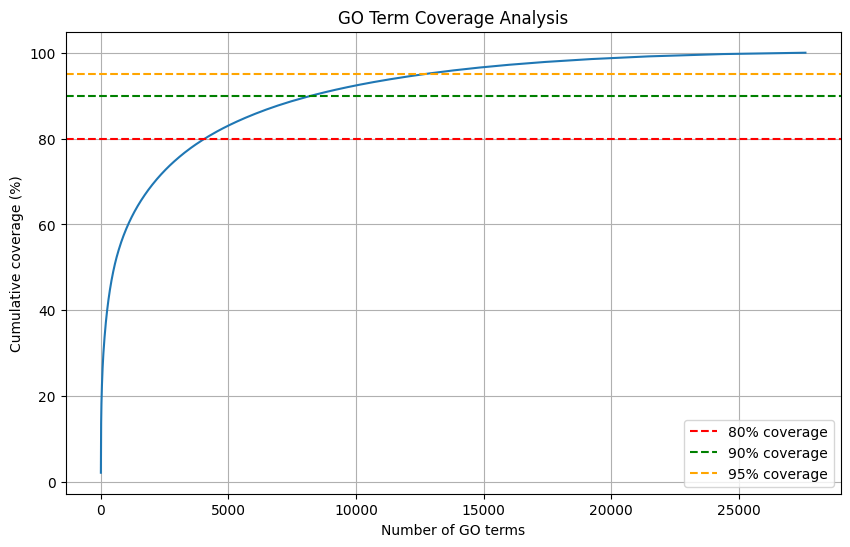

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the frequency counts for ALL GO terms
all_counts = list(go_counts.values())
all_counts.sort(reverse=True)

# Calculate cumulative coverage
total_instances = sum(all_counts)
cumulative_coverage = []
running_sum = 0

for i, count in enumerate(all_counts, 1):
    running_sum += count
    cumulative_coverage.append(running_sum / total_instances * 100)
    
    # Print key milestones
    if i in [100, 500, 1000, 2000, 5000, 10000, len(all_counts)]:
        print(f"Top {i} terms cover: {cumulative_coverage[-1]:.1f}% of all GO term instances")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(all_counts) + 1), cumulative_coverage)
plt.axhline(y=80, color='r', linestyle='--', label='80% coverage')
plt.axhline(y=90, color='g', linestyle='--', label='90% coverage')
plt.axhline(y=95, color='orange', linestyle='--', label='95% coverage')
plt.xlabel('Number of GO terms')
plt.ylabel('Cumulative coverage (%)')
plt.title('GO Term Coverage Analysis')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
print_step_header(7, "SETTING UP ENVIRONMENT")

import torch                 
import torch.nn as nn        # Neural network layers
import torch.optim as optim  # Optimization algorithms (Adam, SGD)
from torch.utils.data import Dataset, DataLoader  # For creating datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# Turn off warning messages for cleaner output
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")
print_memory_usage("After imports")


STEP 7: SETTING UP ENVIRONMENT
✓ All libraries imported successfully
  Memory: 0.63 GB


0.6276283264160156

In [ ]:
print_step_header(8, "SETTING RANDOM SEEDS")

def set_seed(seed=42):
    """Set random seeds for all random number generators"""
    np.random.seed(seed)            # For NumPy random operations
    torch.manual_seed(seed)         # For PyTorch random operations
    print(f"✓ Random seed set to: {seed}")

# Call the function to set seeds
set_seed(42)

print_memory_usage("After setting seeds")


STEP 8: SETTING RANDOM SEEDS
✓ Random seed set to: 42
  Memory: 0.54 GB


0.5387191772460938

In [ ]:
print_step_header(10, "LOADING AND VIEWING DATASET")
from datasets import load_from_disk
    
print("Loading dataset...")
mem_before = print_memory_usage("Before loading")
    
dataset_path = "C:/Users/USER/Documents/cod3astro/ML_AI/ProteinSeq_DL/data/processed/protein_go_dataset"
dataset = load_from_disk(dataset_path)
print(f"✓ Loaded: {len(dataset)} proteins")
    
# Convert to pandas DataFrame 
train_df = dataset.to_pandas()
    
mem_after = print_memory_usage("After loading")
print(f"✓ Memory used: {mem_after - mem_before:.3f} GB")


STEP 10: LOADING AND VIEWING DATASET
Loading dataset...
  Memory: 0.51 GB
✓ Loaded: 105951 proteins
  Memory: 0.52 GB
✓ Memory used: 0.005 GB


In [22]:
train_df.head()

,sequence,accession,label_GO:0005737,label_GO:0005634,label_GO:0005829,label_GO:0005886,label_GO:0005576,label_GO:0046872,label_GO:0005524,label_GO:0016020,...,label_GO:0014033,label_GO:2000767,label_GO:0070251,label_GO:0032474,label_GO:0006726,label_GO:0039588,label_GO:0060117,label_GO:0051965,label_GO:0010626,label_GO:0009630
0,MSLEQKKGADIISKILQIQNSIGKTTSPSTLKTKLSEISRKEQENA...,A0A009IHW8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,MRFQVIVAAATITMITSYIPGVASQSTSDGDDLFVPVSNFDPKSIF...,A0A023I7E1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,MKNPKKKSGGFRIVNMLKRGVARVSPFGGLKRLPAGLLLGHGPIRM...,A0A024B7W1,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,MYRKLAVISAFLATARAQSACTLQSETHPPLTWQKCSSGGTCTQQT...,A0A024RXP8,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,MRSLAILTTLLAGHAFAYPKPAPQSVNRRDWPSINEFLSELAKVMP...,A0A024SC78,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
train_df.describe(include='all')

,sequence,accession,label_GO:0005737,label_GO:0005634,label_GO:0005829,label_GO:0005886,label_GO:0005576,label_GO:0046872,label_GO:0005524,label_GO:0016020,...,label_GO:0014033,label_GO:2000767,label_GO:0070251,label_GO:0032474,label_GO:0006726,label_GO:0039588,label_GO:0060117,label_GO:0051965,label_GO:0010626,label_GO:0009630
count,105951,105951,105951.000000,105951.000000,105951.000000,105951.000000,105951.000000,105951.000000,105951.000000,105951.000000,...,105951.000000,105951.00000,105951.000000,105951.000000,105951.000000,105951.000000,105951.000000,105951.000000,105951.000000,105951.000000
unique,102750,105951,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,GSSGLISMPRV,A0A009IHW8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,55,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,0.213891,0.183472,0.165293,0.163066,0.136167,0.105841,0.098612,0.088135,...,0.000321,0.00051,0.000057,0.000085,0.000047,0.000047,0.000217,0.001652,0.000170,0.000330
std,NaN,NaN,0.410053,0.387055,0.371447,0.369428,0.342967,0.307636,0.298141,0.283493,...,0.017911,0.02257,0.007525,0.009216,0.006869,0.006869,0.014732,0.040608,0.013033,0.018172
min,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [29]:
train_df['seq_length'] = train_df['sequence'].str.len()
train_df['seq_length'].describe()

bins = [0, 50, 100, 200, 256, 512, 1000, 2000, 5000]
labels = [
    '<50', '50–100', '100–200', '200–256',
    '256–512', '512–1000', '1000–2000', '>2000'
]

train_df['length_bin'] = pd.cut(
    train_df['seq_length'],
    bins=bins,
    labels=labels,
    right=False
)

train_df['length_bin'].value_counts().sort_index()


length_bin
<50           5622
50–100        6019
100–200      15837
200–256       8731
256–512      37810
512–1000     23051
1000–2000     7023
>2000         1725
Name: count, dtype: int64

In [36]:
(train_df['seq_length'] > 1024).mean() * 100

np.float64(7.931968551500222)

In [33]:
print(train_df['sequence'].duplicated().sum())
dup_seqs = train_df[train_df['sequence'].duplicated(keep=False)]
dup_seqs

3201


,sequence,accession,label_GO:0005737,label_GO:0005634,label_GO:0005829,label_GO:0005886,label_GO:0005576,label_GO:0046872,label_GO:0005524,label_GO:0016020,...,label_GO:0070251,label_GO:0032474,label_GO:0006726,label_GO:0039588,label_GO:0060117,label_GO:0051965,label_GO:0010626,label_GO:0009630,seq_length,length_bin
5,MIVGILTTLATLATLAASVPLEERQACSSVWGQCGGQNWSGPTCCA...,A0A024SH76,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,471,256–512
28,MVRRIASATPMVQSPMSPLGTTYCVRPNPVSLNLQRRPLVIASTDE...,A0A075TJ05,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,480,256–512
66,MRSSSLAWALGLVALANAQGSPTQWYDSITGVTFSRFYQQDTDASW...,A0A0A8IDB7,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,726,512–1000
112,MGRVTAPEPLSAFHQVAEFVSGEAVLDDWLKQKGLKNQALGAARTF...,A0A0F6B8D8,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,161,100–200
113,MLYKGCLMKSDVQLNLRAKESQRALIDAAAEILHKSRTDFILETAC...,A0A0F6B8D9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,95,50–100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105883,AEYDVSDADIEAFYQ,P83764,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,15,<50
105885,AEYDVSDADIEAFYQ,P83766,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,15,<50
105937,MHNMSDIIEQYIKRLFEESNEDVVEIQRANIAQRFDCVPSQLNYVI...,Q7A799,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,153,100–200
105949,MTIEKNLSDVQQKYADQFQEDVVKSFQTGYGITPDTQIDAGALRRE...,V5XVW4,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,463,256–512


In [37]:
print_step_header(11, 'CREATING DATASET CLASS')

class ProteinDataset(Dataset):
    # Prepares protein sequence for the neural network

    def __init__(self, dataframe=train_df, max_seq_length=1024):
        """
        Initialize the dataset
        Args:
            dataframe: Protein data table
            max_seq_length: Maximum length of protein sequences (shorter ones will be padded)
        """
        self.dataframe = dataframe.reset_index(drop=True)
        self.max_seq_length = max_seq_length  # Using shorter sequences for CPU

        # Find which columns are GO term labels
        # These are all columns except sequence, accession
        self.label_cols = []
        for col in dataframe.columns:
            if col not in ['sequence', 'accession']:
                self.label_cols.append(col)

        # Create dictionary to convert amino acids to numbers
        self.amino_acids = 'ACDEFGHIKLMNPQRSTVWY'  # Standard 20 amino acids
        self.aa_to_idx = {}
        for i, aa in enumerate(self.amino_acids):
            self.aa_to_idx[aa] = i + 1 # Start from 1, 0 will be for padding
        
        print(f"  Found {len(self.label_cols)} GO term labels")

    def __len__(self):
        # Return the number of protein in the dataset
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Get one proteinsequence and its labels
        seq = self.dataframe.iloc[idx]['sequence']

        # Convert sequence to numbers
        seq_encoded = self.encode_sequence(seq)

        # Get the GO term labels
        labels = self.dataframe.iloc[idx][self.label_cols].values.astype(np.float32)

        # Return as pytorn tensors
        return{
            'sequence': torch.tensor(seq_encoded, dtype=torch.long),
            'labels': torch.tensor(labels, dtype=torch.float32)
        }
    def encode_sequence(self, sequence):
        # Convert amino acids strings to a list of numbers
        encoded = []
        # Take only first max_seq_length if amino acids if sequence is too long
        if len(sequence) > self.max_seq_length:
            sequence = sequence[:self.max_seq_length]

            # convert each amino acid to its number
            for aa in sequence:
                if aa in self.aa_to_idx:
                    encoded.append(self.aa_to_idx[aa])
                else:
                    encoded.append(0)
                
            # If sequence is too short
            while len(encoded) < self.max_seq_length:
                encoded.append(0)
            return encoded

print("✓ ProteinDataset class created")
print_memory_usage("After creating dataset class")


STEP 11: CREATING DATASET CLASS
✓ ProteinDataset class created
  Memory: 0.49 GB


0.4855690002441406

In [38]:
print_step_header(12, "SPLITTING DATA")

mem_before = print_memory_usage("Before splitting data")

# First split: 70% training, 30% temporary
train_data, temp_data = train_test_split(train_df, test_size=0.3, random_state=42)

# Split temporary data: 50% validation, 50% test (15% each of total)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

# Create dataset objects for each split
train_dataset = ProteinDataset(train_data, max_seq_length=256)
val_dataset = ProteinDataset(val_data, max_seq_length=256)
test_dataset = ProteinDataset(test_data, max_seq_length=256)

print(f"✓ Data split completed:")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Test samples: {len(test_dataset)}")

# Track memory after splitting
mem_after = print_memory_usage("After splitting data")
print(f"  Memory used by splits: {mem_after - mem_before:.2f} GB")

# Force garbage collection to free memory
gc.collect()
print("  Garbage collection performed")
print_memory_usage("After garbage collection")


STEP 12: SPLITTING DATA
  Memory: 0.49 GB
  Found 1002 GO term labels
  Found 1002 GO term labels
  Found 1002 GO term labels
✓ Data split completed:
  Training samples: 74165
  Validation samples: 15893
  Test samples: 15893
  Memory: 0.80 GB
  Memory used by splits: 0.32 GB
  Garbage collection performed
  Memory: 0.80 GB


0.8021011352539062

In [27]:
print_step_header(13, "CREATING CNN MODEL")

class SimpleProteinCNN(nn.Module):
    """Simple CNN for protein function prediction"""
    
    def __init__(self, num_classes=100):
        """
        Initialize the CNN
        Args:
            num_classes: Number of GO terms to predict
        """
        super(SimpleProteinCNN, self).__init__()
        
        # Embedding layer: converts amino acid numbers to vectors
        # 21 = 20 amino acids + 1 for padding/unknown
        self.embedding = nn.Embedding(21, 64, padding_idx=0)
        
        # First CNN layer
        self.conv1 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        
        # Second CNN layer
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=5, padding=2)
        
        # Third CNN layer
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=7, padding=3)
        
        # Global pooling - takes the most important features
        self.pool = nn.AdaptiveMaxPool1d(1)
        
        # First fully connected layer
        self.fc1 = nn.Linear(32, 128)
        
        # Dropout for preventing overfitting
        self.dropout = nn.Dropout(0.3)
        
        # Second fully connected layer
        self.fc2 = nn.Linear(128, 64)
        
        # Output layer - one neuron for each GO term
        self.output = nn.Linear(64, num_classes)
        
        # Activation function
        self.relu = nn.ReLU()
    
    def forward(self, x):
        """
        Forward pass through the network
        Args:
            x: Input tensor with shape (batch_size, sequence_length)
        Returns:
            Predictions for each GO term
        """
        # Step 1: Convert amino acid numbers to vectors
        x = self.embedding(x)  # Shape: (batch, seq_len, 64)
        x = x.permute(0, 2, 1)  # Shape: (batch, 64, seq_len)
        
        # Step 2: Apply CNN layers
        x = self.relu(self.conv1(x))  # Apply first CNN + activation
        x = self.relu(self.conv2(x))  # Apply second CNN + activation
        x = self.relu(self.conv3(x))  # Apply third CNN + activation
        
        # Step 3: Global pooling
        x = self.pool(x)  # Shape: (batch, 32, 1)
        x = x.squeeze(-1)  # Shape: (batch, 32)
        
        # Step 4: Fully connected layers
        x = self.relu(self.fc1(x))  # First FC layer + activation
        x = self.dropout(x)  # Apply dropout
        x = self.relu(self.fc2(x))  # Second FC layer + activation
        x = self.dropout(x)  # Apply dropout again
        
        # Step 5: Output layer (no activation here - will be applied later)
        x = self.output(x)  # Shape: (batch, num_classes)
        
        return x

print("✓ SimpleProteinCNN class created")

# Count how many parameters the model has
sample_model = SimpleProteinCNN(num_classes=len(train_dataset.label_cols))
total_params = sum(p.numel() for p in sample_model.parameters())
print(f"  Model parameters: {total_params:,}")

print_memory_usage("After creating model")


STEP 13: CREATING CNN MODEL
✓ SimpleProteinCNN class created
  Model parameters: 158,920
  Memory: 0.15 GB


0.14644241333007812